In [1]:
import numpy as np
import time 
import matplotlib.pyplot as plt
from util import *

%load_ext autoreload
%autoreload 2

In [2]:
MicroArray,Labels = read_data(mode="CellType",th=20)
print MicroArray.shape,Labels.shape

IOError: [Errno 2] No such file or directory: 'Gene_Chip_Data/E-TABM-185.sdrf.txt'

19
4 293.0
11 20.0
56.6842105263


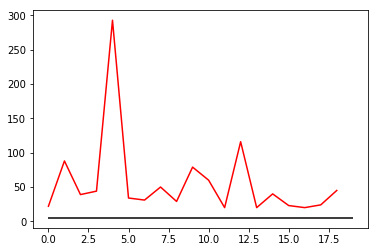

In [45]:
import matplotlib.pyplot as plt
uniq = np.unique(Labels)
distribution = np.zeros(len(uniq))

print len(uniq)
for i in range(len(Labels)):
    distribution[int(Labels[i])] += 1
    
print np.argmax(distribution),np.max(distribution)
print np.argmax(-distribution),np.min(distribution)
print np.mean(distribution)
#plt.ylim(0,100)
plt.hlines(5,0,len(uniq))

plt.plot(distribution,"r")
plt.show()

# Do naive linear regression without data processing

In [46]:
## shuffle data and divide it into train & set
from util import *

MicroArray_train,MicroLabels_train,MicroArray_test,MicroLabels_test = division(MicroArray,Labels)

MicroLabels_train = MicroLabels_train.reshape([MicroLabels_train.shape[0]])
MicroLabels_test = MicroLabels_test.reshape([MicroLabels_test.shape[0]])

print MicroArray_train.shape
print MicroArray_test.shape
print MicroLabels_train.shape
print MicroLabels_test.shape

(869, 22283)
(208, 22283)
(869,)
(208,)


In [47]:
import liblinearutil as linear_classifier

tic = time.time()
prob = linear_classifier.problem(MicroLabels_train,MicroArray_train)

param = linear_classifier.parameter('-s 0 -c 20 -B 1')
model = linear_classifier.train(prob,param)

p_label,p_acc,p_val = linear_classifier.predict(MicroLabels_test,MicroArray_test,model)
ACC,MSE,SCC = linear_classifier.evaluations(MicroLabels_test,p_label)

p_label,p_acc,p_val = linear_classifier.predict(MicroLabels_train,MicroArray_train,model)
ACC,MSE,SCC = linear_classifier.evaluations(MicroLabels_train,p_label)

toc = time.time()

print "total time:",toc-tic
print ACC

Accuracy = 88.9423% (185/208) (classification)
Accuracy = 97.3533% (846/869) (classification)
total time: 93.3808269501
97.3532796318


# Try PCA

In [39]:
def rel_error(x, y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [48]:
ProjArray = pca(MicroArray,0.95)
print ProjArray.shape

883
(1077, 883)


In [49]:
## shuffle data and divide it into 5 parts
from util import *

ProjLabels = Labels
ProjArray_train,ProjLabels_train,ProjArray_test,ProjLabels_test = division(ProjArray,ProjLabels)
ProjLabels_train = ProjLabels_train.reshape([ProjLabels_train.shape[0]])
ProjLabels_test = ProjLabels_test.reshape([ProjLabels_test.shape[0]])

print ProjArray_train.shape
print ProjArray_test.shape
print ProjLabels_train.shape
print ProjLabels_test.shape

(869, 883)
(208, 883)
(869,)
(208,)


## do linear regression after pca

In [50]:
import liblinearutil as linear_classifier

tic = time.time()
prob = linear_classifier.problem(ProjLabels_train,ProjArray_train)
param = linear_classifier.parameter('-s 0 -c 20 -B 1')
model = linear_classifier.train(prob,param)

p_label,p_acc,p_val = linear_classifier.predict(ProjLabels_test,ProjArray_test,model)
ACC,MSE,SCC = linear_classifier.evaluations(ProjLabels_test,p_label)

p_label,p_acc,p_val = linear_classifier.predict(ProjLabels_train,ProjArray_train,model)
ACC,MSE,SCC = linear_classifier.evaluations(ProjLabels_train,p_label)
toc = time.time()

print "total time:",toc-tic
print ACC

Accuracy = 67.3077% (140/208) (classification)
Accuracy = 97.3533% (846/869) (classification)
total time: 10.6990580559
97.3532796318


# Do robust PCA

In [13]:
from rpca import *
A = rpcaADMM(MicroArray)
LowRank = A['X3_admm']


iter	    r norm	   eps pri	    s norm	  eps dual	 objective
   1	10066.5644	  170.3670	16951.8514	  167.3954	55639467.50
  10	 4100.3474	  254.1957	 2464.8443	  157.9858	185887442.58
  20	 1050.3421	  250.3522	  544.5018	   99.7027	147792733.97
  30	  384.6562	  243.4925	  203.7492	   99.9190	138657192.63


In [47]:
np.linalg.matrix_rank(LowRank)

1

In [48]:
np.save("ct_lowrank",LowRank)

In [18]:
# singualr values already stored in descending order
LR_U, LR_sing_vals, LR_V = np.linalg.svd(LowRank, full_matrices=False)

In [87]:
cut = 100
LR_U_cut = LR_U[:,0:cut]
LR_sing_cut = LR_sing_vals[0:cut]
LR_V_cut = LR_V[0:cut,:]
LR_ProjArray = MicroArray.dot(LR_V_cut.T)
#LR_ProjArray = LR_U_cut.dot(np.diag(LR_sing_cut))

print LR_ProjArray.shape

(1077, 100)


In [88]:
## shuffle data and divide it into 5 parts
from util import *

LR_ProjLabels = Labels
LR_ProjArray_train,LR_ProjLabels_train,LR_ProjArray_test,LR_ProjLabels_test = division(LR_ProjArray,LR_ProjLabels)
LR_ProjLabels_train = LR_ProjLabels_train.reshape([LR_ProjLabels_train.shape[0]])
LR_ProjLabels_test = LR_ProjLabels_test.reshape([LR_ProjLabels_test.shape[0]])

print LR_ProjArray_train.shape
print LR_ProjArray_test.shape
print LR_ProjLabels_train.shape
print LR_ProjLabels_test.shape

(869, 100)
(208, 100)
(869,)
(208,)


## low rank PCA to do linear regression

In [89]:
import liblinearutil as linear_classifier

tic = time.time()
prob = linear_classifier.problem(LR_ProjLabels_train,LR_ProjArray_train)
param = linear_classifier.parameter('-s 0 -c 20 -B 1')
model = linear_classifier.train(prob,param)

p_label,p_acc,p_val = linear_classifier.predict(LR_ProjLabels_test,LR_ProjArray_test,model)
ACC,MSE,SCC = linear_classifier.evaluations(LR_ProjLabels_test,p_label)
toc = time.time()

print "total time:",toc-tic
print ACC

Accuracy = 86.0577% (179/208) (classification)
total time: 0.381976127625
86.0576923077
